<a href="https://colab.research.google.com/github/garynico/IndoBERT-Hoax/blob/main/IndoBERT_Hoax_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IndoBERT for Bahasa Indonesia Hoax News Detection

### Import library

In [1]:
import pandas as pd 
import numpy as np 
import torch

!pip install transformers
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Preliminaries
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models
import torch.nn as nn

# Training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

     |████████████████████████████████| 1.5MB 12.6MB/s 
     |████████████████████████████████| 2.9MB 44.8MB/s 
     |████████████████████████████████| 890kB 48.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=05b79a29ed7ecd9aa3e7ddc531b295d8321a15eb358ffe55bb7ce206fa3e795c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
# Drive
from google.colab import files
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
source_folder = '/content/drive/My Drive/transformers/Data'
destination_folder = '/content/drive/My Drive/transformers/Model'

In [4]:
%cd /content/drive/My Drive/transformers/Data

/content/drive/My Drive/transformers/Data


## Preliminaries

In [5]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Model

In [7]:
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.int64)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('tanggal', text_field),('judul', text_field),('narasi', text_field),('label', label_field)]

train,valid,test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv', test='test.csv', 
                                           format='csv', fields=fields, skip_header=True)



In [8]:
# Iterators
train_iter = BucketIterator(train, batch_size=8, sort_key=lambda x: len(x.narasi),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=8, sort_key=lambda x: len(x.narasi),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=8, device=device, train=False, shuffle=False, sort=False)

In [9]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "indobenchmark/indobert-base-p1"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [10]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

## Training and Validation

In [11]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 8,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (date, title, text, labels), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            output = model(text, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (date, title, text, labels), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        output = model(text, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [12]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Step [277/4440], Train Loss: 0.7311, Valid Loss: 0.7105
Model saved to ==> /content/drive/My Drive/transformers/Model/model.pt
Model saved to ==> /content/drive/My Drive/transformers/Model/metrics.pt
Epoch [1/8], Step [554/4440], Train Loss: 0.7228, Valid Loss: 0.7014
Model saved to ==> /content/drive/My Drive/transformers/Model/model.pt
Model saved to ==> /content/drive/My Drive/transformers/Model/metrics.pt
Epoch [2/8], Step [831/4440], Train Loss: 0.6553, Valid Loss: 0.6197
Model saved to ==> /content/drive/My Drive/transformers/Model/model.pt
Model saved to ==> /content/drive/My Drive/transformers/Model/metrics.pt
Epoch [2/8], Step [1108/4440], Train Loss: 0.6224, Valid Loss: 0.5725
Model saved to ==> /content/drive/My Drive/transformers/Model/model.pt
Model saved to ==> /content/drive/My Drive/transformers/Model/metrics.pt
Epoch [3/8], Step [1385/4440], Train Loss: 0.4375, Valid Loss: 0.5369
Model saved to ==> /content/drive/My Drive/transformers/Model/model.pt
Model 

Model loaded from <== /content/drive/My Drive/transformers/Model/metrics.pt


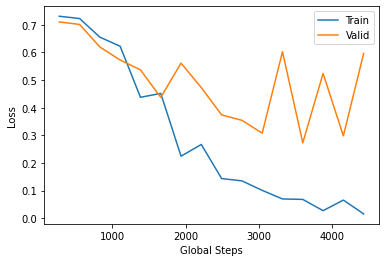

In [13]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from <== /content/drive/My Drive/transformers/Model/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9479    0.9452    0.9465       693
           0     0.9453    0.9481    0.9467       693

    accuracy                         0.9466      1386
   macro avg     0.9466    0.9466    0.9466      1386
weighted avg     0.9466    0.9466    0.9466      1386



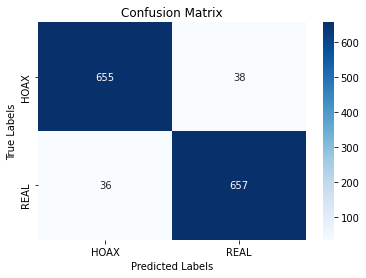

In [14]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (date, title, text, labels), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['HOAX', 'REAL'])
    ax.yaxis.set_ticklabels(['HOAX', 'REAL'])

best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)